### Corpus creation

In [2]:
import nltk
nltk.download('gutenberg')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import gutenberg
from string import punctuation
import re
import numpy as np


[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/fernankiwi/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fernankiwi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fernankiwi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
a = punctuation
print(a)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [5]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [6]:
wpt

WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)

In [7]:
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [8]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    # re.I|re.A: are flags indicating that the pattern matching should be case-insensitive (re.I) 
    # and that the ^ and $ special characters should match the start and end of each line, (re.A).
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [9]:
# np.vectorize is a NumPy function that creates a vectorized version of a Python function.
# It takes a Python function (in this case, normalize_document) as an argument and returns 
# a new function that can operate element-wise on arrays or lists.
normalize_corpus = np.vectorize(normalize_document)

In [10]:
normalize_corpus

In [11]:
bible = gutenberg.sents('bible-kjv.txt')
remove_terms = punctuation + '0123456789'

In [12]:
bible[:3]

[['[', 'The', 'King', 'James', 'Bible', ']'],
 ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'],
 ['The', 'First', 'Book', 'of', 'Moses', ':', 'Called', 'Genesis']]

In [13]:
remove_terms

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [14]:
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
# Apply the normalize_corpus function to each document in the norm_bible dataset
# and filtering out any elements that evaluate to False after normalization.
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

In [15]:
print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


### CBOW model 3 layer NN

First step is to generate a vocabulary for hot encode from corpus

In [16]:
from keras.preprocessing import text
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


Now, we must create our traing dataset for CBOW model, X features represent the context of the sentences and Y the targer or prediction, Note: because computing this corpus is high expensive (needs GPU and almost 2 hours training) I will limit the corpus consume

In [ ]:
from keras.utils import to_categorical

def generate_context_word_pairs(corpus, window_size, vocab_size,corpus_size):
    context_length = window_size*2
    for words in corpus[:corpus_size]:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []
            start = index - window_size
            end = index + window_size + 1

            context_words.append([words[i]
                                 for i in range(start, end)
                                 if 0 <= i < sentence_length
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = to_categorical(label_word, vocab_size)
            yield (x, y)


# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size,corpus_size=12000):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])

        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


Now, lets create our 3 Layer model for prediction and start training

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            1242500   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12425)             1254925   
                                                                 
Total params: 2497425 (9.53 MB)
Trainable params: 2497425 (9.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


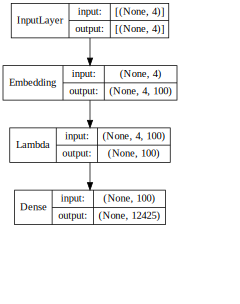

In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False,
                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
for epoch in range(1, 4):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size,corpus_size=1000):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 1000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)

Processed 1000 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 3000 (context, word) pairs
Processed 4000 (context, word) pairs
Processed 5000 (context, word) pairs
Processed 6000 (context, word) pairs
Processed 7000 (context, word) pairs
Processed 8000 (context, word) pairs
Processed 9000 (context, word) pairs
Processed 10000 (context, word) pairs
Processed 11000 (context, word) pairs
Processed 12000 (context, word) pairs
Epoch: 1 	Loss: 103413.75121499039
Processed 1000 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 3000 (context, word) pairs
Processed 4000 (context, word) pairs
Processed 5000 (context, word) pairs
Processed 6000 (context, word) pairs
Processed 7000 (context, word) pairs
Processed 8000 (context, word) pairs
Processed 9000 (context, word) pairs
Processed 10000 (context, word) pairs
Processed 11000 (context, word) pairs
Processed 12000 (context, word) pairs
Epoch: 2 	Loss: 101892.24747592397
Processed 1000 (context, word) pairs

Lets find out out embeddings vectors

In [ ]:
import pandas as pd

weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
unto,-0.078823,-1.936725,-0.911094,0.150300,-1.127869,0.167821,-0.063582,-0.209456,-0.814784,-0.199894,...,-0.465335,-0.675688,-0.803697,-0.796188,-0.337746,-0.180304,0.724837,0.520966,0.164926,2.114064
lord,-0.493733,-4.316750,0.423517,-0.001842,-3.292756,-0.313364,0.986502,0.508764,-1.656482,1.421112,...,0.532534,-1.002122,-0.689739,-0.181971,0.131372,0.667447,0.202572,0.408737,0.507488,3.707379
thou,-0.034997,-1.807771,0.319117,-0.582285,-1.160614,0.218042,0.363625,0.171865,-1.012269,0.822735,...,0.357490,-0.771305,-0.553631,0.176274,-0.051367,0.424594,0.187359,0.341353,0.433901,1.619914
thy,-0.262120,-2.382391,0.823473,1.784971,-1.773342,-1.330658,-0.146427,-0.499931,-0.969622,0.169681,...,-0.251314,-0.773625,-0.948643,-0.541344,-0.441159,-1.201772,0.541223,0.956601,-0.222844,1.946750
god,-0.466611,-2.419438,0.311234,0.422515,-1.490485,-0.331374,-0.156032,-0.003239,-0.882634,0.386995,...,-0.156325,-0.477876,-0.791342,-0.343604,-0.190243,-0.482595,0.181577,0.475327,0.630946,2.228725


Lets bring now some similar (semantic) words by using eucledian distance

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'god': ['lord', 'wife', 'went', 'thy', 'behold'],
 'jesus': ['elioenai', 'famous', 'revolted', 'err', 'mephibosheth'],
 'noah': ['two', 'saying', 'ark', 'saw', 'three'],
 'egypt': ['brethren', 'pharaoh', 'spake', 'told', 'gave'],
 'john': ['purification', 'cutting', 'pedahel', 'honeycomb', 'diotrephes'],
 'gospel': ['western', 'mnason', 'betray', 'shout', 'gnawed'],
 'moses': ['hill', 'furious', 'reading', 'gittite', 'shamefully'],
 'famine': ['greatly', 'lights', 'buy', 'ears', 'benjamin']}

## skip gram model using word2vec

Lets create a vocabulary based on target-context window

In [ ]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0],
          id2word[pairs[i][1]], pairs[i][1],
          labels[i]))

(bible (5766), ichabod (7224)) -> 0
(king (13), james (1154)) -> 1
(bible (5766), james (1154)) -> 1
(king (13), bible (5766)) -> 1
(james (1154), king (13)) -> 1
(king (13), forest (1386)) -> 0
(james (1154), bible (5766)) -> 1
(bible (5766), king (13)) -> 1
(bible (5766), friendship (7848)) -> 0
(james (1154), sleeping (4445)) -> 0


Lets create a model

In [ ]:
from keras.layers import Dot
from keras.layers import Dense, Reshape
from keras.layers import Embedding
from keras.models import Sequential
from keras.models import Model

word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

model_arch = Dot(axes=1)([word_model.output, context_model.output])
model_arch = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(model_arch)
model = Model([word_model.input,context_model.input], model_arch)

model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_9_input (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_10_input (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                                  
 embedding_9 (Embedding)     (None, 1, 100)               1242500   ['embedding_9_input[0][0]']   
                                                                                              

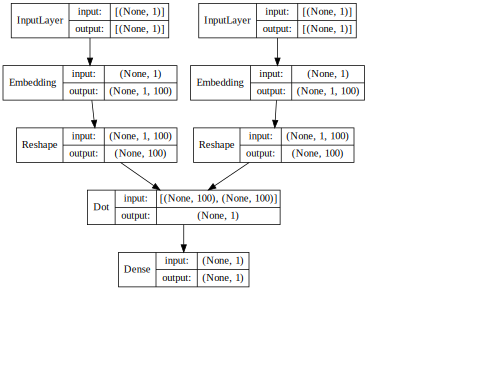

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False,
                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
for epoch in range(1, 6):
    loss = 0
    elements = [(i, elem) for i, elem in enumerate(skip_grams)][:2000]
    for (i, elem) in elements:
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 1000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 1000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 230.3106653894065
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 1000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 205.39374822960235
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 1000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 196.23869638651377
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 1000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 189.07380601775367
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 1000 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 183.6152190058492


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'god': ['lord', 'wife', 'went', 'thy', 'behold'],
 'jesus': ['elioenai', 'famous', 'revolted', 'err', 'mephibosheth'],
 'noah': ['two', 'saying', 'ark', 'saw', 'three'],
 'egypt': ['brethren', 'pharaoh', 'spake', 'told', 'gave'],
 'john': ['purification', 'cutting', 'pedahel', 'honeycomb', 'diotrephes'],
 'gospel': ['western', 'mnason', 'betray', 'shout', 'gnawed'],
 'moses': ['hill', 'furious', 'reading', 'gittite', 'shamefully'],
 'famine': ['greatly', 'lights', 'buy', 'ears', 'benjamin']}

Total words: 48 	Word Embedding shapes: (48, 100)


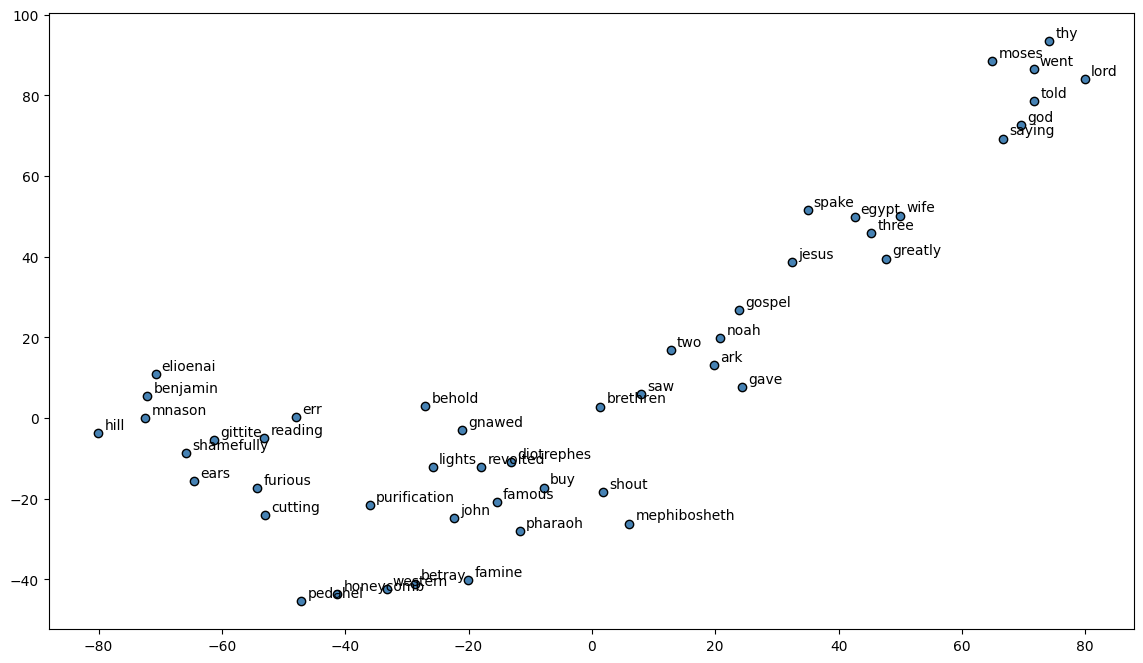

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Gensim for word2vec

In [ ]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality
window_context = 30          # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size =feature_size,
                          window=window_context, min_count=min_word_count,
                          sample=sample, epochs =50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['lord', 'worldly', 'reasonable', 'henceforth', 'glory'],
 'jesus': ['peter', 'messias', 'impotent', 'james', 'immediately'],
 'noah': ['shem', 'ham', 'japheth', 'noe', 'henoch'],
 'egypt': ['pharaoh', 'egyptians', 'bondage', 'rod', 'flowing'],
 'john': ['baptist', 'james', 'devine', 'peter', 'galilee'],
 'gospel': ['faith', 'christ', 'godly', 'sufferings', 'teaching'],
 'moses': ['congregation', 'children', 'joshua', 'elisheba', 'ordinance'],
 'famine': ['pestilence', 'peril', 'noisome', 'blasting', 'trespassing']}

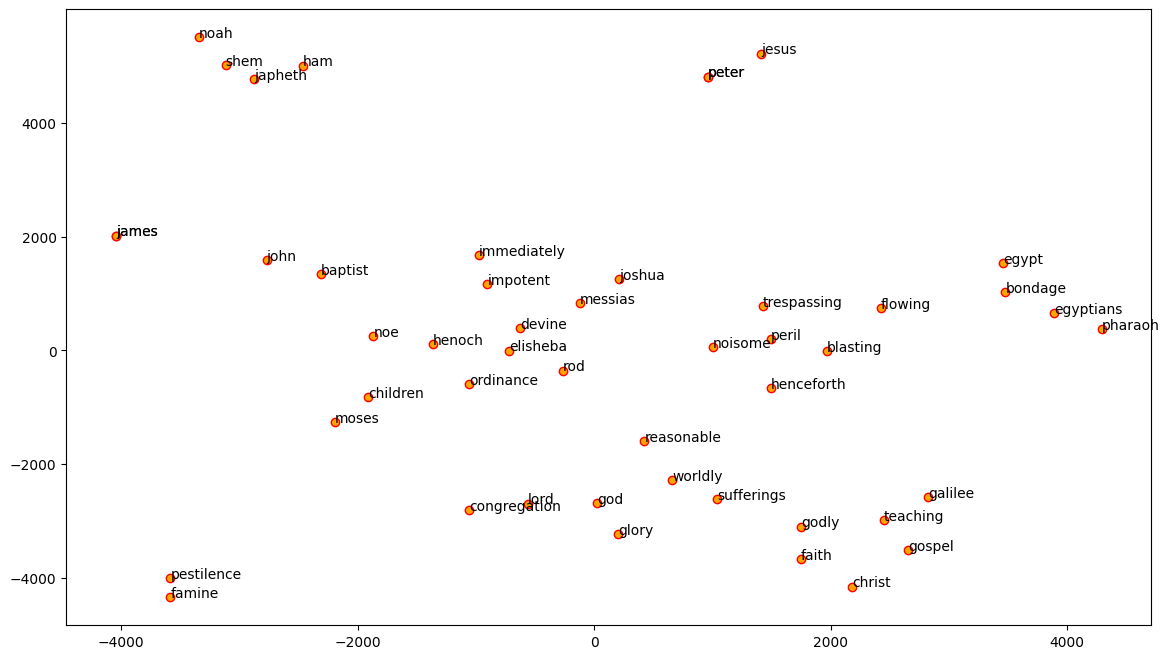

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')